In this file, we set up the Random Forest Classifier (RFC) ensembles and ROC Curve Methodology.
The RFC is what we use to actually make predictions, and the ROC Curves are used to compare the predictive power

## ROC Functions 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import pandas as pd
import numpy as np
# import os

from ipywidgets import IntProgress
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import CubicSpline
from colour import Color
from matplotlib import gridspec


#Data Type for ROC graphs (Data name, False Positives, True Positives, False Negatives, True Negatives)
def ROC_DATA(label, FP='-', TP='-', FN='-', TN='-', THRESHOLD='-'):
    obj = {'Label':label }
    if(not(FP is '-')):
        obj['FP'] = FP
    if(not(FN is '-')):
        obj['FN'] = FN
    if(not(TP is '-')):
        obj['TP'] = TP
    if(not(TN is '-')):
        obj['TN'] = TN
    if(not(THRESHOLD is '-')):
        obj['THRESHOLD'] = THRESHOLD
    return obj



#makes ROC_DATA for all columns in a df
def getRate(df, col, label='Default'):
    FP, TP = [], []
    FN, TN = [], []
    THRESHOLD = []
    for i in range(0, 100):
        threshold=i/100.
        THRESHOLD.append(threshold)
        FP.append(len(df[(df[col]<threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
        TP.append(len(df[(df[col]<threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        FN.append(len(df[(df[col]>threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        TN.append(len(df[(df[col]>threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
    return ROC_DATA(label, TP=TP, FP=FP, TN=TN, FN=FN, THRESHOLD=THRESHOLD)

#Plot a single ROC_DATA with THRESHOLD as a second x-axis
def plotRocThreshold(rocData):
    fig = plt.figure()
    fig.set_size_inches(5, 5)
    ax = fig.add_subplot(1,1,1)
    
    d = skimROC_Data(rocData, addTresh=True)
    label = d['Label']
    
    FP, TP = d['FP'], d['TP']
    THRESHOLD = d['THRESHOLD']

    ax.plot(FP,TP,'-' ,label = "FP", alpha=.8, color='black')
    ax.plot(THRESHOLD,TP,'-' ,label = "Threshold", color='red', linewidth = .5)

    ax.set_xlabel('%')
    ax.set_xlim(0,1)
    ax.set_ylabel('TP %')
    ax.set_ylim(0,1)
    ax.set_title(label+ " ROC + Thresholds")
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend()


#Plot an array of ROC_DATA
def plotRocs(rocObjArray):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(1,1,1)
    for rocData in rocObjArray:
        d = skimROC_Data(rocData)
        label = d['Label']
        FP, TP = d['FP'], d['TP']
        ax.plot(FP,TP,'-' ,label = label,zorder = -32, alpha=.5)
    handles, labels = ax.get_legend_handles_labels()
    display = (0,71)
    ax.set_xlabel('FP Rate')
    ax.set_xlim(0,1)
    ax.set_ylabel('TP Rate')
    ax.set_ylim(0,1)
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
    ax.set_title('ROC Curve Compliation')
    ax.legend()
    
    
#Limits columns in a DF to  particular value
def limitVal(df, ignore = ['Success'], N = 1.):
    for c in df.drop(columns=ignore).columns:
        if(not (df[c].dtype == 'bool')):
            df[c] = df[c].where(df[c] <= 1., 1.) 
    return df


#Takes the average of all columns in a df
def avgVal(df, ignore = ['Success'], colName = "AvgPred", JUST_PREDS=False):
    df[colName] = df.drop(columns=ignore).mean(axis=1)
    return df



In [22]:

colormap = list(Color("red").range_to(Color("green"),100))
def mapToColors(values):
    colors = []
    for v in values:
        i = int(v*100)
        colors.append(str(colormap[i]))
    return colors


#Plot a single ROC_DATA with THRESHOLD as a second graph
def plotColorRoc(rocData, title=''):
    # plot it
    fig = plt.figure(figsize=(6, 5)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, .25]) 

    ax0 = plt.subplot(gs[0])
    d = rocData
    label = d['Label']
    
    FP, TP = d['FP'], d['TP']
    THRESHOLD = d['THRESHOLD']
    COLORS = mapToColors(THRESHOLD)
    for i in range(1, len(FP)):
        ax0.plot((FP[i-1], FP[i]),(TP[i-1], TP[i]), c = COLORS[i], label = "FP", lw=3.)
        
    ax0.set_xlabel('False Positive Rate')
    ax0.set_xlim(0,1)
    ax0.set_ylabel('True Positive Rate')
    ax0.set_ylim(0,1)
    ax0.set_title(title)
        
    ax0.grid(color='black', linestyle='-', linewidth=1, alpha=.5)


    ax1 = plt.subplot(gs[1])
    ax1.yaxis.tick_right()
    ax1.set_xlim(0,1)
    ax1.get_xaxis().set_visible(False)
    ax1.set_ylabel('Threshold')
    ax1.set_ylim(0,1)

    values = np.arange(0., 1., .01)
    for i in range(0, 100):
        plt.plot((0, 1.), (values[i], values[i]), c = str(colormap[i]), lw=4)

## Forest Functions

In [3]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

#Samples DF for an approximate number of rows  (Needed for balanceDF)
def cutDF(df, intendedNumber):
    df = df.sample(frac=intendedNumber/len(df), replace=True)
    return df

#Returns DF with 50/50 split on specified binary column
def balanceDF(df, colName, numberOfEach = 0):
    failDF = df[df[colName]==False]
    successDF = df[df[colName]==True]
    if(numberOfEach == 0):
        maxContestsForBalance = min(len(successDF), len(failDF))
        numberOfEach = int(maxContestsForBalance*.1)
    combinedDF = pd.concat([cutDF(successDF, numberOfEach), cutDF(failDF, numberOfEach)])
    return combinedDF

#Splits a df into two parts, for testing and training
def splitTrainingTesting(df, percentTrain, TYPE='None', basedOnVault=False):
    if(not basedOnVault):
        df = df.copy(deep=True)
        if(TYPE=="CLF"):
            df['Success'] = df['Success'].astype('int')
        elif(TYPE=='REGR'):
            df['Success'] = df['Success'].astype('float')
        df['is_train'] = np.random.uniform(0, 1, len(df)) <= percentTrain
        trainDF, testDF = df[df['is_train']==True], df[df['is_train']==False]
        df = df.drop(columns=['is_train'], axis=1)
        trainDF = trainDF.drop(['is_train'], axis=1)
        testDF = testDF.drop(['is_train'], axis=1)
        return trainDF, testDF
    else:
        nonVault = pd.merge(nonVaultDF, df, on='ContestId', how='left')
        vault = df[~df.index.isin(nonVault.index)].dropna()
        numTrain = len(nonVault)
        numTest = int((1-percentTrain)*numTrain)
        vault.sample(n=numTest, random_state=1)
        return nonVault, vault.sample(n=numTest, random_state=1)


#Simple wrapper for making a classifier
def classifierWrapper(trainDF, classifierType, balanced=True):
    trainDF = trainDF.copy(deep=True)
    if(balanced):
        trainDF = balanceDF(trainDF, 'Success')
    clf = makeAndTrainCLF(trainDF, classifierType)
    columns = trainDF.columns.drop('Success')
    return {"clf":clf, "cols":columns}

#Trains a classifier of the provided DF
def makeAndTrainCLF(trainDF, classifierType, successCol = 'Success'):
    clf = classifierType()
    clf.fit(trainDF[trainDF.columns.drop(successCol)], trainDF[successCol].astype('int'))
    return clf


def EnsembleWithMinAcc(trainDF, classifierType, balanced=True, numCLF = 20, accuracy=0.):
    CLFS = []
    for i in range(0, numCLF):
        currAcc = -1.
        while(currAcc < accuracy):
            clf = classifierWrapper(trainDF, RandomForestClassifier, balanced=balanced)
            currAcc = accuracy_score(clf['clf'].predict(trainDF[clf['cols']]), trainDF['Success'])
        CLFS.append(clf)
    return CLFS

def getEnsPred(testDF, CLFS):
    rDF = testDF[['Success']].copy(deep=True)
    count = 0
    for CLF in CLFS:
        count+=1
        classifier, columns = CLF['clf'], CLF['cols']
        rDF['CLF'+str(count)] = classifier.predict(testDF[columns])
    return rDF

### Data Files for ROC

In [4]:
fullContests = pd.read_csv('data/WorkingData.csv').set_index('ContestId')

In [9]:
# Percent Full at 4 hours out
baselineDF = pd.read_csv('data/Baseline.csv').drop(columns=['Unnamed: 0'])

# Meta Data file
metaDataDF = pd.read_csv('data/MetaData.csv')

# Kalman Filter
kfResultsDF = pd.read_csv('data/KF_Results.csv')

# Linear Regression
lrResultsDF = pd.read_csv('data/LR_Results.csv')

In [15]:
#Pacer Data (Current DraftKings prediction at 4 hours out)
pacerDF = pd.read_csv('data/DK_Pacer_Success.csv').set_index('ContestId')

In [10]:
trainDF = pd.read_csv("data/Vault/train.csv").set_index('ContestId')
testDF = pd.read_csv("data/Vault/test1.csv").set_index('ContestId')
print("Number of contests in trainDF:",len(trainDF))
print("Number of contests in testDF:",len(testDF))

Number of contests in trainDF: 373711
Number of contests in testDF: 66522


### ROC Curves based on single columns

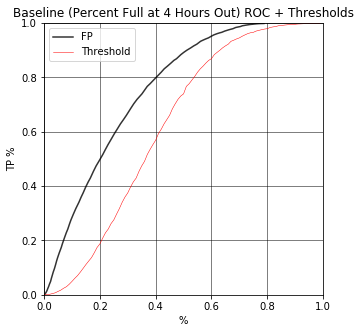

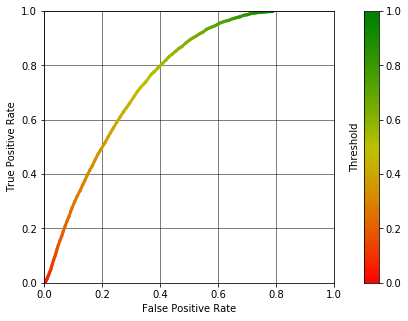

In [26]:
# print("... Calculating Baseline 4-hours-out Prediction")
baselineRates = getRate(baselineDF, 'FourHoursOut_Scaled', label='Baseline (Percent Full at 4 Hours Out)')
plotRocThreshold(baselineRates)
plotColorRoc(baselineRates)

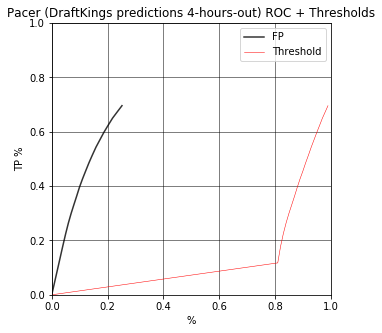

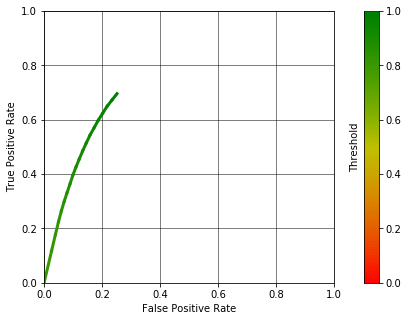

In [25]:
pacerRates = getRate(pacerDF, 'PacerSuccess', label='Pacer (DraftKings predictions 4-hours-out)')
plotRocThreshold(pacerRates)
plotColorRoc(pacerRates)

### ROC Curves based on RFC Enesembles

In [27]:
metaColumns = list(metaDataDF.columns.drop('ContestId'))
metaColumns.append('Success')
metaTrain, metaTest = trainDF[metaColumns], testDF[metaColumns]

In [28]:
metaCLFS = EnsembleWithMinAcc(limitVal(metaTrain), RandomForestClassifier, accuracy = .6)
metaPreds = avgVal(getEnsPred(limitVal(metaTest), metaCLFS))

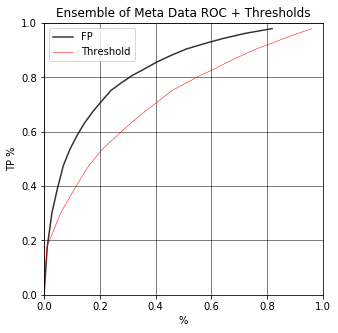

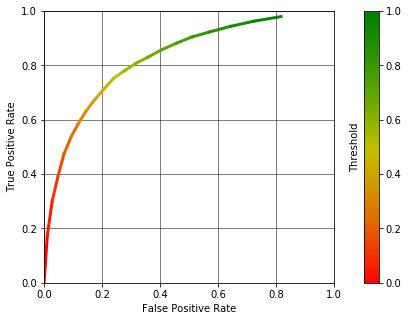

In [29]:
metaEnsembleRates =  getRate(metaPreds, 'AvgPred', label='Ensemble of Meta Data')
plotRocThreshold(metaEnsembleRates)
plotColorRoc(metaEnsembleRates)

### Comparing ROC Curves

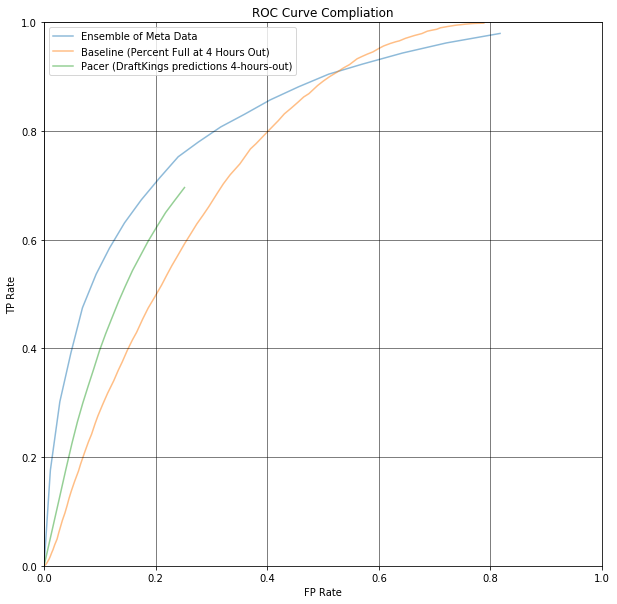

In [30]:
plotRocs([metaEnsembleRates, baselineRates, pacerRates])